In [251]:
""" Script regresses control models against RNN RDM to find best fit"""

In [1591]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
import scipy
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


from cryptic_rnn import *

In [1651]:
## functions

def tuple_output(tuple_step, cue_dict):
    out = cue_dict[tuple_step[1]]
    if tuple_step[0]=='-':
        out = -1*out
    return out

#### functions ###################
def control_importance(rdm, val_idx, all_seqs, cuedict):

    outs_truth = change_dict(all_seqs, cuedict)
    outs_truth = [t[-1] for t in outs_truth]
    truth_RDM = abs(np.array([outs_truth]*16) - np.array([outs_truth]*16).T)
       
    outs_aug = change_dict(all_seqs, cuedict)
    outs_aug = [tuple_output(t[0], cuedict) for t in outs_aug]
    aug_RDM = abs(np.array([outs_aug]*16) - np.array([outs_aug]*16).T)

    y = []
    x_truth = []
    x_aug = []
    for p in val_idx:
        for q in val_idx:
            y.append(rdm[p,q])
            x_truth.append(truth_RDM[p,q])
            x_aug.append(aug_RDM[p,q])

    y = np.array(y)#.reshape(-1,1)
    x = pd.DataFrame({'ground_truth': np.array(x_truth),
                      'aug_control': np.array(x_aug)})
    
    lm = ols('y ~ ground_truth + aug_control',x).fit()
    lm.params
    anova_table = anova_lm(lm)
    var_vals = anova_table.loc[:,'sum_sq'] / anova_table['sum_sq'].sum()
    var_exp = np.array(var_vals[:-1])
    return var_exp

def get_step_coeffs(RDMs, step_num):
    importance_vals = np.empty((0,2))
    for i, rdm_mat in enumerate(RDMs[step_num]):
        imps = control_importance(rdm_mat, val_idx, all_seqs, ft_cue_dicts[i])
        importance_vals = np.vstack([importance_vals, imps])
   
    coeff_vals = importance_vals.T.reshape(-1)
    print(len(RDMs[0]))
    N = len(RDMs[0])
    control_mod = ['ground truth']*N + ['augend']*N
    return coeff_vals, control_mod

def all_steps_coeffs(RDM_set):
    all_coeffs = np.empty((0,1))
    all_controls = []
    step_num = []
    for st in range(4):
        print('step ', st)
        step_coeffs, step_mods = get_step_coeffs(RDM_set, step_num=st)
        all_coeffs = np.append(all_coeffs, step_coeffs)
        all_controls += step_mods
        step_num += [st+1]*len(step_mods)
    return pd.DataFrame({'step': step_num, 'variance explained': all_coeffs, 'control':all_controls})

def regress_single_control(rdm_list, cuedict_list, val_idx, all_seqs):
    all_r2s = []
    for i, rdm in enumerate(rdm_list):
        cuedict = cuedict_list[i]
        
        outs_truth = np.linspace(-10, 10 , len(all_seqs))
        truth_RDM = abs(np.array([outs_truth]*16) - np.array([outs_truth]*16).T)

        y = []
        x_truth = []
        for p in val_idx:
            for q in val_idx:
                y.append(rdm[p,q])
                x_truth.append(truth_RDM[p,q])
                
        y = np.array(y)#.reshape(-1,1)
        x = pd.DataFrame({'ground_truth': np.array(x_truth)})

        lm = ols('y ~ ground_truth',x).fit()
        lm.params
        anova_table = anova_lm(lm)
        var_vals = anova_table.loc[:,'sum_sq'] / anova_table['sum_sq'].sum()
        var_exp = np.array(var_vals[:-1])
        all_r2s.append(var_exp[0])
    return all_r2s

def shear_theta(xy, theta):
    xx, yy = xy
    csq = xx**2 + yy**2 - 2*xx*yy*math.cos(theta*math.pi/180)
    return csq**0.5

def scale_addnd(xy, scale):
    xx, yy = xy
    return xx + yy*scale

def shear_importance(rdm, val_idx, all_seqs, cuedict):
    
    augs = np.repeat([cuedict['A'], cuedict['B'], cuedict['C'], cuedict['D']], 4)
    adds = np.array([cuedict['A'], cuedict['B'], cuedict['C'], cuedict['D']]*4)

    aug_dist = np.empty((16,16))
    add_dist = np.empty((16,16))
    for p in range(16):
        for q in range(16):
            aug_dist[p, q] = augs[p]-augs[q]
            add_dist[p, q] = adds[p]-adds[q]

    y = []
    aug_truth = []
    add_truth = []
    for p in val_idx:
        for q in val_idx:
            y.append(rdm[p,q])
            aug_truth.append(aug_dist[p, q])
            add_truth.append(add_dist[p, q])

    parameters, covariance = curve_fit(shear_theta, (aug_truth, add_truth), y)
    p0 = parameters[0]
    
    shear_truth = [shear_theta((aug_truth[i], add_truth[i]), p0) for i in range(len(y))]

    y = np.array(y)
    x = pd.DataFrame({'shear_control': shear_truth})
    
    lm = ols('y ~  shear_control',x).fit()
    
    lm.params
    anova_table = anova_lm(lm)
    var_vals = anova_table.loc[:,'sum_sq'] / anova_table['sum_sq'].sum()
    var_exp = np.array(var_vals[:-1])
    
    return p0, var_exp[0]

def get_step_coeffs_shear(RDMs, step_num):
    importance_vals = []
    p0vals = []
    for i, rdm_mat in enumerate(RDMs[step_num]):
        p0, imp = shear_importance(rdm_mat, val_idx, all_seqs, ft_cue_dicts[i])
        importance_vals.append(imp)
        p0vals.append(p0)

    return importance_vals, p0vals

def scale_importance(rdm, val_idx, all_seqs, cuedict):
    
    augs = np.repeat([cuedict['A'], cuedict['B'], cuedict['C'], cuedict['D']], 4)
    adds = np.array([cuedict['A'], cuedict['B'], cuedict['C'], cuedict['D']]*4)

    aug_dist = np.empty((16,16))
    add_dist = np.empty((16,16))
    for p in range(16):
        for q in range(16):
            aug_dist[p, q] = augs[p]-augs[q]
            add_dist[p, q] = adds[p]-adds[q]

    y = []
    aug_truth = []
    add_truth = []
    for p in val_idx:
        for q in val_idx:
            y.append(rdm[p,q])
            aug_truth.append(aug_dist[p, q])
            add_truth.append(add_dist[p, q])

    parameters, covariance = curve_fit(scale_addnd, (aug_truth, add_truth), y)
    p0 = parameters[0]
    
    scale_truth = [scale_addnd((aug_truth[i], add_truth[i]), p0) for i in range(len(y))]

    y = np.array(y)
    x = pd.DataFrame({'scale_control': shear_truth})
    
    lm = ols('y ~  scale_control',x).fit()
    
    lm.params
    anova_table = anova_lm(lm)
    var_vals = anova_table.loc[:,'sum_sq'] / anova_table['sum_sq'].sum()
    var_exp = np.array(var_vals[:-1])
    
    return p0, var_exp[0]

def get_step_coeffs_scale(RDMs, step_num):
    importance_vals = []
    p0vals = []
    for i, rdm_mat in enumerate(RDMs[step_num]):
        p0, imp = scale_importance(rdm_mat, val_idx, all_seqs, ft_cue_dicts[i])
        importance_vals.append(imp)
        p0vals.append(p0)

    return importance_vals, p0vals

In [1593]:
# RNN params
num_classes = 22
batchsize=1
hidden_size = 20

rank_dict = {'A': -1.5, 'B': -0.5, 'C':0.5 , 'D':1.5 }
## sequences
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
primitives = generate_pos_primitives(all_syms, cue_dict)

trainseqs = generate_pos_other(ops, all_syms[:-1], cue_dict)
trainseqs_b = generate_pos_other(ops, all_syms[:-1], cue_dict) + generate_balanced_primitives(ops, all_syms, cue_dict)
trainseqs_p = trainseqs + primitives
trainseqs_bp = trainseqs_b + primitives

all_seqs = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
testseqs = [seq for seq in all_seqs if seq not in trainseqs_b]
val_idx = [idx for idx, seq in enumerate(all_seqs) if seq not in trainseqs_b]

## read data 
save_dir = '../results/corrected/addition_trigrams_3inputs_bp_800'
with open(save_dir, 'rb') as f:
    res1 = pickle.load(f)
    
full_rdmats = calculate_RDMs(res1, testseqs_all, subset = 'all')
dms = full_rdmats['rdms']
dms_p = full_rdmats['rdms_p']
dms_b = full_rdmats['rdms_b']
dms_bp = full_rdmats['rdms_bp']
ft_cue_dicts =  full_rdmats['ft_cue_dicts']

no. 100% trained RNNs:  800


In [1595]:
df_p = all_steps_coeffs(dms_p)
df_b = all_steps_coeffs(dms_b)

step  0
800
step  1
800
step  2
800
step  3
800
step  0
800
step  1
800
step  2
800
step  3
800


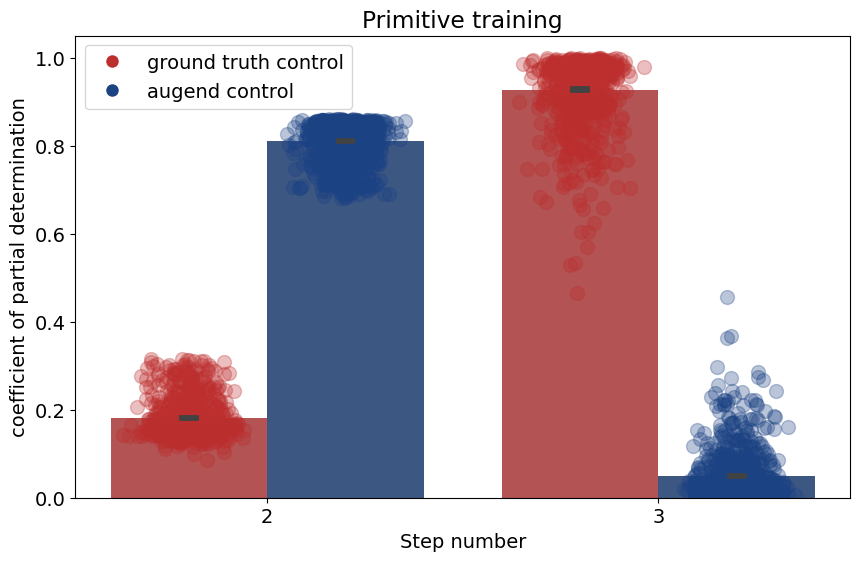

In [1640]:
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[0], markersize=10, label='ground truth control'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[1], markersize=10, label='augend control')]
colors = ['#BD2E2E', '#1B4283']

df_p_23 = df_p[df_p['step'].isin(steps)]


steps = [2,3]
shift = 0.2
N = len(dms_b[0])
xpos = np.array([[0-shift]*N, [0+shift]*N, [1-shift]*N, [1+shift]*N])
x_jitter = xpos + np.random.normal(0, 0.05, 4*N).reshape(4, N)

y1 = df_p[(df_p['step'] == steps[0])&(df_p['control'] == 'ground truth')]['variance explained']
y2 = df_p[(df_p['step'] == steps[0])&(df_p['control'] == 'augend')]['variance explained']
y3 = df_p[(df_p['step'] == steps[1])&(df_p['control'] == 'ground truth')]['variance explained']
y4 = df_p[(df_p['step'] == steps[1])&(df_p['control'] == 'augend')]['variance explained']
ys = [y1 , y2, y3, y4]

fig, axs = plt.subplots()
sns.barplot(df_p_23, x = 'step', y='variance explained', hue='control', errorbar="se", alpha=0.9, palette=colors, capsize=0.04)

for i in range(4):
    axs.scatter(x_jitter[i,:], ys[i], alpha=0.3, color =colors[i%2], s=100, label = labels[i%2])
axs.set_ylabel('coefficient of partial determination')
axs.set_xticks(np.arange(len(steps)))
axs.set_xticklabels(steps)
axs.set_xlabel('Step number')
axs.title.set_text('Primitive training')
axs.legend(handles=legend_elements)

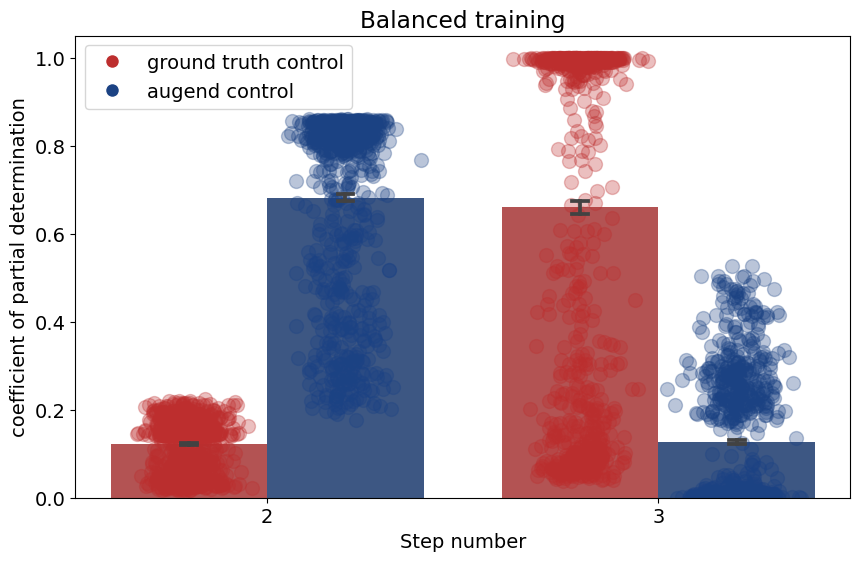

In [1642]:
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[0], markersize=10, label='ground truth control'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[1], markersize=10, label='augend control')]
colors = ['#BD2E2E', '#1B4283']

df_b_23 = df_b[df_b['step'].isin(steps)]

steps = [2,3]
shift = 0.2
N = len(dms_b[0])
xpos = np.array([[0-shift]*N, [0+shift]*N, [1-shift]*N, [1+shift]*N])
x_jitter = xpos + np.random.normal(0, 0.05, 4*N).reshape(4, N)

y1 = df_b[(df_b['step'] == steps[0])&(df_b['control'] == 'ground truth')]['variance explained']
y2 = df_b[(df_b['step'] == steps[0])&(df_b['control'] == 'augend')]['variance explained']
y3 = df_b[(df_b['step'] == steps[1])&(df_b['control'] == 'ground truth')]['variance explained']
y4 = df_b[(df_b['step'] == steps[1])&(df_b['control'] == 'augend')]['variance explained']
ys = [y1 , y2, y3, y4]

fig, axs = plt.subplots()
sns.barplot(df_b_23, x = 'step', y='variance explained', hue='control', errorbar="se", alpha=0.9, palette=colors, capsize=0.04)

for i in range(4):
    axs.scatter(x_jitter[i,:], ys[i], alpha=0.3, color =colors[i%2], s=100, label = labels[i%2])
axs.set_ylabel('coefficient of partial determination')
axs.set_xticks(np.arange(len(steps)))
axs.set_xticklabels(steps)
axs.set_xlabel('Step number')
axs.title.set_text('Balanced training')
axs.legend(handles=legend_elements)

In [1784]:
import statannot


In [1760]:
df_p.columns

Index(['step', 'variance explained', 'control'], dtype='object')

In [1773]:
dfp3 = df_p[df_p['step']==3].copy()
dfp3['Regime'] = np.repeat(['Primitives'],N*2)
dfb3 = df_b[df_b['step']==3].copy()
dfb3['Regime'] = np.repeat(['Balanced'],N*2)

df3 = pd.concat([dfb3, dfp3])

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Balanced_ground truth v.s. Primitives_ground truth: Wilcoxon test (paired samples) with Bonferroni correction, P_val=9.172e-18 stat=1.036e+05
Using zero_method  wilcox
Balanced_augend v.s. Primitives_augend: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.706e-14 stat=1.095e+05


Text(0.5, 1.1, 'Step 3: Control RDM fits')

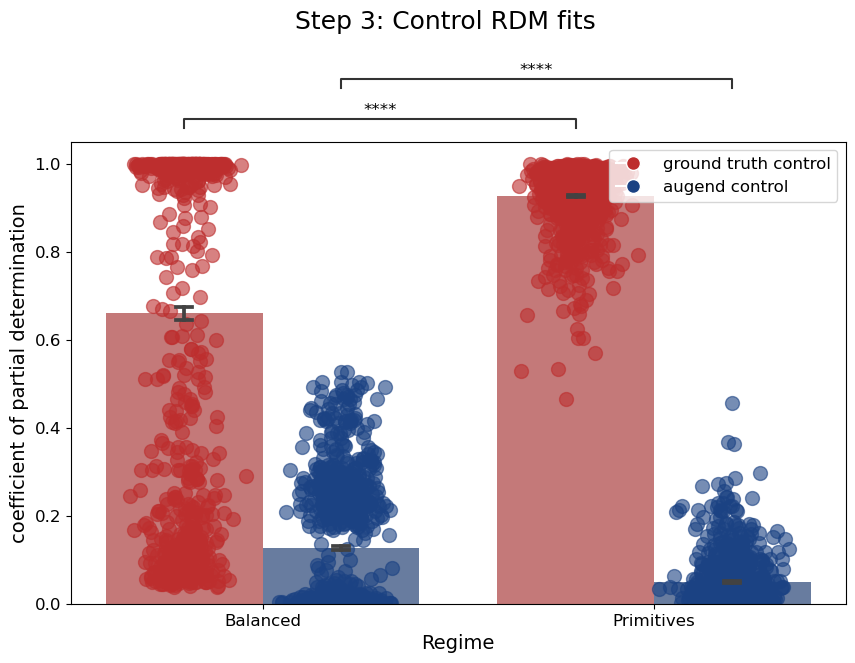

In [1801]:
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[0], markersize=10, label='ground truth control'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[1], markersize=10, label='augend control')]
colors = ['#BD2E2E', '#1B4283']

shift = 0.2
N = len(dms_b[0])
xpos = np.array([[0-shift]*N, [0+shift]*N, [1-shift]*N, [1+shift]*N])
x_jitter = xpos + np.random.normal(0, 0.05, 4*N).reshape(4, N)

y1 = df3[(df3['Regime'] == 'Balanced')&(df3['control'] == 'ground truth')]['variance explained']
y2 = df3[(df3['Regime'] == 'Balanced')&(df3['control'] == 'augend')]['variance explained']
y3 = df3[(df3['Regime'] == 'Primitives')&(df3['control'] == 'ground truth')]['variance explained']
y4 = df3[(df3['Regime'] == 'Primitives')&(df3['control'] == 'augend')]['variance explained']
ys = [y1 , y2, y3, y4]

fig, axs = plt.subplots()
sns.barplot(df3, x = 'Regime', y='variance explained', hue='control', errorbar="se", alpha=0.7, palette=colors, capsize=0.04)

for i in range(4):
    axs.scatter(x_jitter[i,:], ys[i], alpha=0.6, color =colors[i%2], s=100, label = labels[i%2])
axs.set_ylabel('coefficient of partial determination')
axs.set_xticks(np.arange(len(steps)))
axs.set_xticklabels(['Balanced', 'Primitives'])
axs.set_xlabel('Regime')
axs.legend(handles=legend_elements, loc='upper right')

statannot.add_stat_annotation(
    axs,
    data=df3,
    x='Regime',
    y='variance explained',
    hue='control',
    box_pairs=[(('Balanced', 'ground truth'), ('Primitives', 'ground truth')),
               (('Balanced', 'augend'), ('Primitives', 'augend'))],
    test="Wilcoxon",
    text_format="star",
    loc="outside",
)

plt.suptitle('Step 3: Control RDM fits', y = 1.1)

In [1795]:
dfp2 = df_p[df_p['step']==2].copy()
dfp2['Regime'] = np.repeat(['Primitives'],N*2)
dfb2 = df_b[df_b['step']==2].copy()
dfb2['Regime'] = np.repeat(['Balanced'],N*2)

df2 = pd.concat([dfb2, dfp2])

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Balanced_ground truth v.s. Primitives_ground truth: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.428e-26 stat=9.003e+04
Using zero_method  wilcox
Balanced_augend v.s. Primitives_augend: Wilcoxon test (paired samples) with Bonferroni correction, P_val=4.781e-73 stat=4.176e+04


Text(0.5, 1.1, 'Step 2: Control RDM fits')

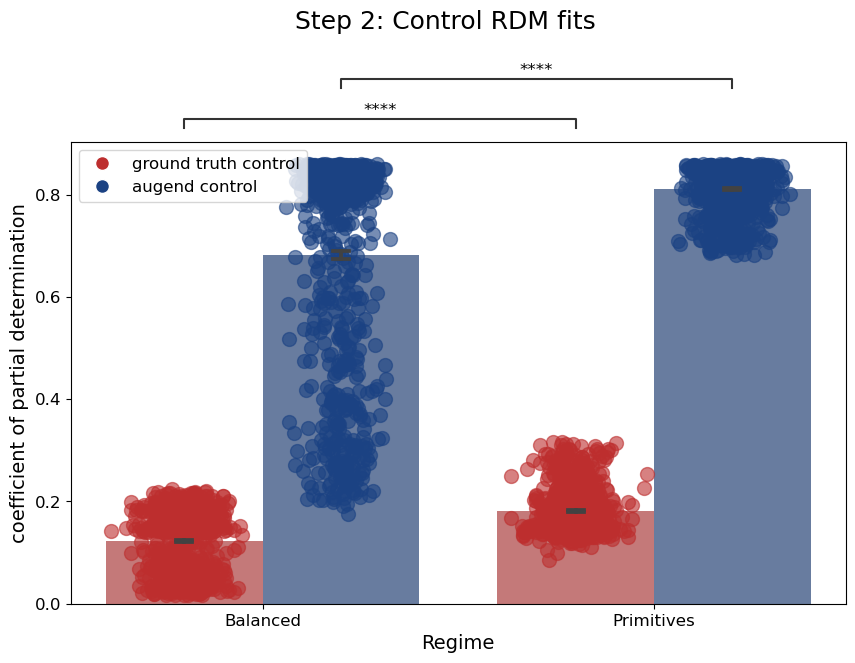

In [1829]:
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[0], markersize=10, label='ground truth control'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[1], markersize=10, label='augend control')]
colors = ['#BD2E2E', '#1B4283']

shift = 0.2
N = len(dms_b[0])
xpos = np.array([[0-shift]*N, [0+shift]*N, [1-shift]*N, [1+shift]*N])
x_jitter = xpos + np.random.normal(0, 0.05, 4*N).reshape(4, N)

y1 = df2[(df2['Regime'] == 'Balanced')&(df2['control'] == 'ground truth')]['variance explained']
y2 = df2[(df2['Regime'] == 'Balanced')&(df2['control'] == 'augend')]['variance explained']
y3 = df2[(df2['Regime'] == 'Primitives')&(df2['control'] == 'ground truth')]['variance explained']
y4 = df2[(df2['Regime'] == 'Primitives')&(df2['control'] == 'augend')]['variance explained']
ys = [y1 , y2, y3, y4]

fig, axs = plt.subplots()
sns.barplot(df2, x = 'Regime', y='variance explained', hue='control', errorbar="se", alpha=0.7, palette=colors, capsize=0.04)

for i in range(4):
    axs.scatter(x_jitter[i,:], ys[i], alpha=0.6, color =colors[i%2], s=100, label = labels[i%2])
axs.set_ylabel('coefficient of partial determination')
axs.set_xticks(np.arange(len(steps)))
axs.set_xticklabels(['Balanced', 'Primitives'])
axs.set_xlabel('Regime')
axs.legend(handles=legend_elements, loc='upper left')

statannot.add_stat_annotation(
    axs,
    data=df2,
    x='Regime',
    y='variance explained',
    hue='control',
    box_pairs=[(('Balanced', 'ground truth'), ('Primitives', 'ground truth')),
               (('Balanced', 'augend'), ('Primitives', 'augend'))],
    test="Wilcoxon",
    text_format="star",
    loc="outside",
)

plt.suptitle('Step 2: Control RDM fits', y = 1.1)

In [1775]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [1706]:
# plot heatmaps

In [ ]:
def flatten_to_strings(listOfLists):
    """Flatten a list of (lists of (lists of strings)) for any level 
    of nesting"""
    result = []

    for i in listOfLists:
        # Only append if i is a basestring (superclass of string)
        if isinstance(i, str):
            result.append(i)
        # Otherwise call this function recursively
        else:
            result.extend(flatten_to_strings(i))
    return result

In [1707]:
eq_seq = [seq[:-1] for seq in all_seqs]
seqlabs = [' '.join(list(itertools.chain(*eq_s))) for eq_s in eq_seq]

In [1724]:
outs_truth = change_dict(all_seqs, cuedict)
outs_truth = [t[-1] for t in outs_truth]
truth_RDM = abs(np.array([outs_truth]*16) - np.array([outs_truth]*16).T)

outs_aug = change_dict(all_seqs, cuedict)
outs_aug = [tuple_output(t[0], cuedict) for t in outs_aug]
aug_RDM = abs(np.array([outs_aug]*16) - np.array([outs_aug]*16).T)


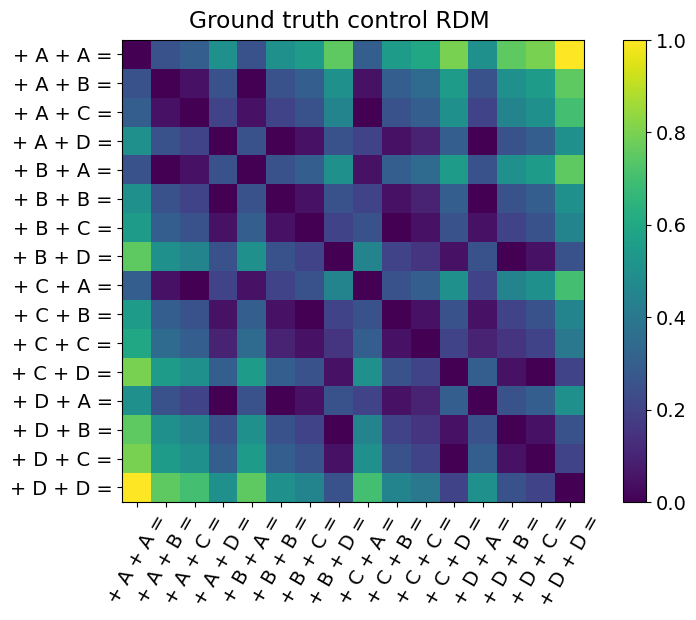

In [1723]:
fig, ax = plt.subplots()
ax.imshow(truth_RDM)
f = ax.set_xticks(np.arange(16))
f = ax.set_xticklabels(seqlabs, rotation=60)
f = ax.set_yticks(np.arange(16))
f = ax.set_yticklabels(seqlabs, rotation=0)
plt.suptitle('Ground truth control RDM', y=0.93)
fig.colorbar(cm.ScalarMappable(cmap='viridis'), ax=ax)

In [1803]:
auglabs = [seq[:3] for seq in seqlabs]


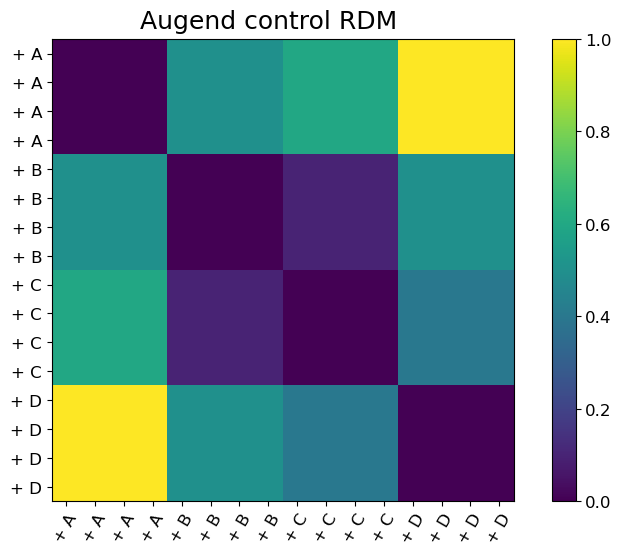

In [1804]:
fig, ax = plt.subplots()
ax.imshow(aug_RDM)
f = ax.set_xticks(np.arange(16))
f = ax.set_xticklabels(auglabs, rotation=60)
f = ax.set_yticks(np.arange(16))
f = ax.set_yticklabels(auglabs, rotation=0)
plt.suptitle('Augend control RDM', y=0.93)
fig.colorbar(cm.ScalarMappable(cmap='viridis'), ax=ax)

Text(0.5, 0.93, 'Primitive regime')

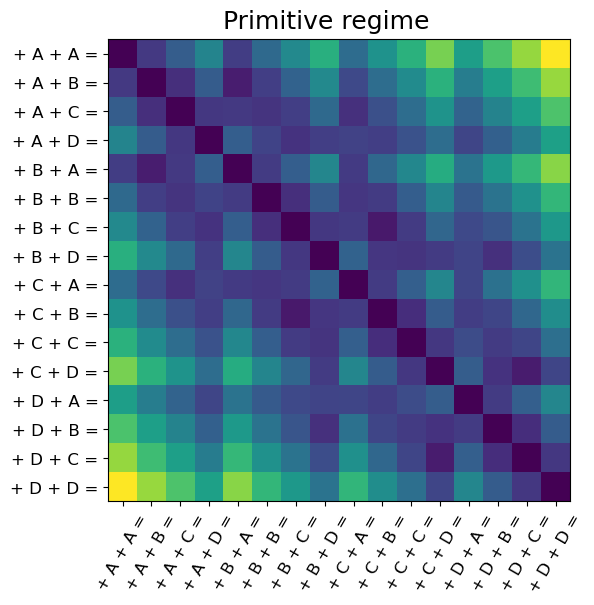

In [1824]:
fig, ax = plt.subplots()
ax.imshow(np.array(dms_p[2]).mean(axis=0))
f = ax.set_xticks(np.arange(16))
f = ax.set_xticklabels(seqlabs, rotation=60)
f = ax.set_yticks(np.arange(16))
f = ax.set_yticklabels(seqlabs, rotation=0)
plt.suptitle('Primitive regime', y=0.93)


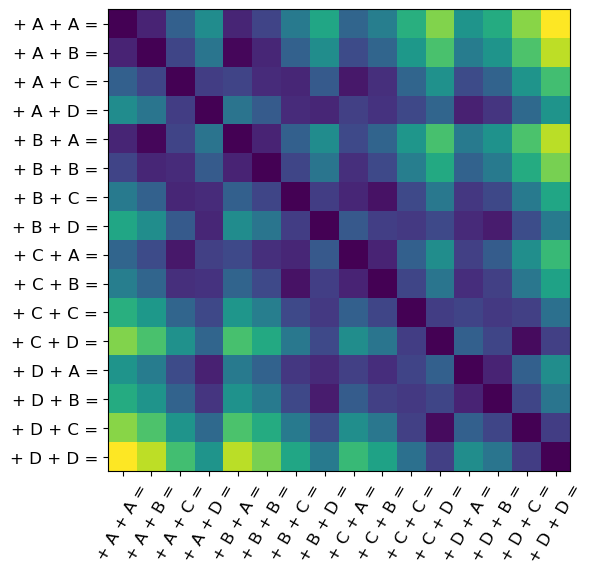

In [1826]:
fig, ax = plt.subplots()
ax.imshow(np.array(dmb_acc).mean(axis=0))
f = ax.set_xticks(np.arange(16))
f = ax.set_xticklabels(seqlabs, rotation=60)
f = ax.set_yticks(np.arange(16))
f = ax.set_yticklabels(seqlabs, rotation=0)
#plt.suptitle('> 50% accurate; Balanced regime', y=0.93)


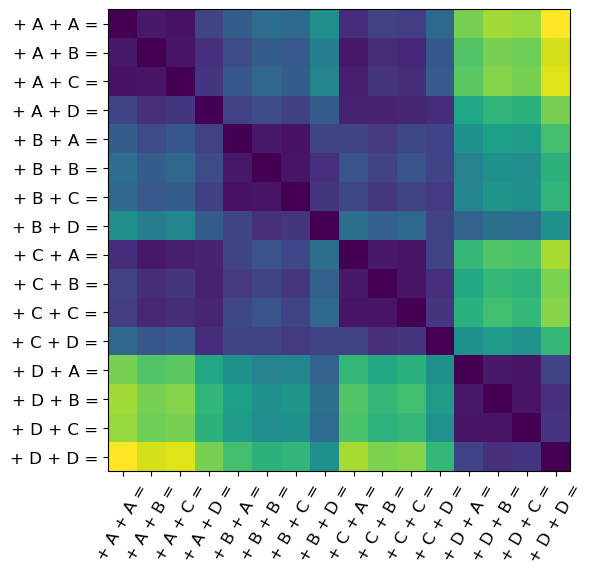

In [1827]:
fig, ax = plt.subplots()
ax.imshow(np.array(dmb_inacc).mean(axis=0))
f = ax.set_xticks(np.arange(16))
f = ax.set_xticklabels(seqlabs, rotation=60)
f = ax.set_yticks(np.arange(16))
f = ax.set_yticklabels(seqlabs, rotation=0)
#plt.suptitle('< 50% accurate; Balanced regime', y=0.93)


In [1730]:
SMALL_SIZE = 2
MEDIUM_SIZE = 2
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
 

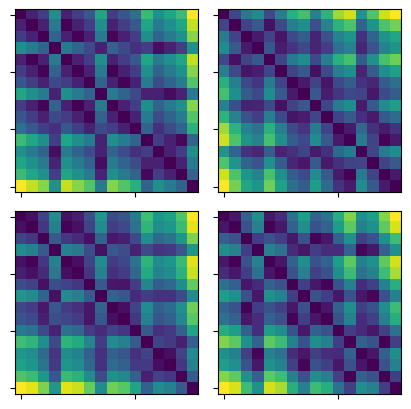

In [1807]:
fig, axs = plt.subplots(2,2, figsize=(5,5))
axs=axs.flatten()

for j, i in enumerate(acc_ind[:4]):
    ax = axs[j]
    plt.axis('on')
    ax.imshow(dms_b[2][i])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
# f = ax.set_xticks(np.arange(16))
# f = ax.set_xticklabels(seqlabs, rotation=60)
# f = ax.set_yticks(np.arange(16))
# f = ax.set_yticklabels(seqlabs, rotation=0)
# plt.suptitle('Augend control RDM', y=0.93)
# fig.colorbar(cm.ScalarMappable(cmap='viridis'), ax=ax)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

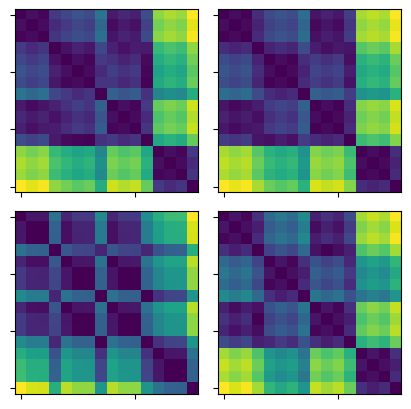

In [1808]:
fig, axs = plt.subplots(2,2, figsize=(5,5))
axs=axs.flatten()

for j, i in enumerate(inacc_ind[:4]):
    ax = axs[j]
    plt.axis('on')
    ax.imshow(dms_b[2][i])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
# f = ax.set_xticks(np.arange(16))
# f = ax.set_xticklabels(seqlabs, rotation=60)
# f = ax.set_yticks(np.arange(16))
# f = ax.set_yticklabels(seqlabs, rotation=0)
# plt.suptitle('Augend control RDM', y=0.93)
# fig.colorbar(cm.ScalarMappable(cmap='viridis'), ax=ax)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

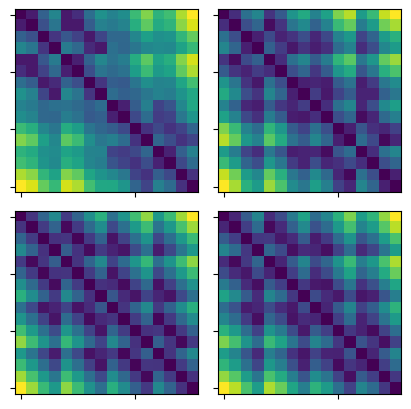

In [1815]:
fig, axs = plt.subplots(2,2, figsize=(5,5))
axs=axs.flatten()

for i, j in enumerate(range(8,12)):
    ax = axs[i]
    plt.axis('on')
    ax.imshow(dms_p[2][j])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
# f = ax.set_xticks(np.arange(16))
# f = ax.set_xticklabels(seqlabs, rotation=60)
# f = ax.set_yticks(np.arange(16))
# f = ax.set_yticklabels(seqlabs, rotation=0)
# plt.suptitle('Augend control RDM', y=0.93)
# fig.colorbar(cm.ScalarMappable(cmap='viridis'), ax=ax)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

In [1806]:
accdf = res1['acc_df']
acc_ind = accdf[accdf['acc_test_b'] > 0.5].index
inacc_ind = accdf[accdf['acc_test_b'] < 0.5].index

In [1816]:
plt.imshow(matlist_p[2])

NameError: name 'matlist_p' is not defined

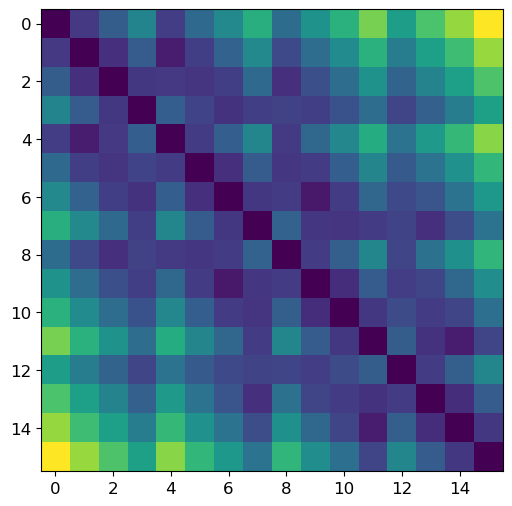

In [1818]:
plt.imshow(np.array(dms_p[2]).mean(axis=0))

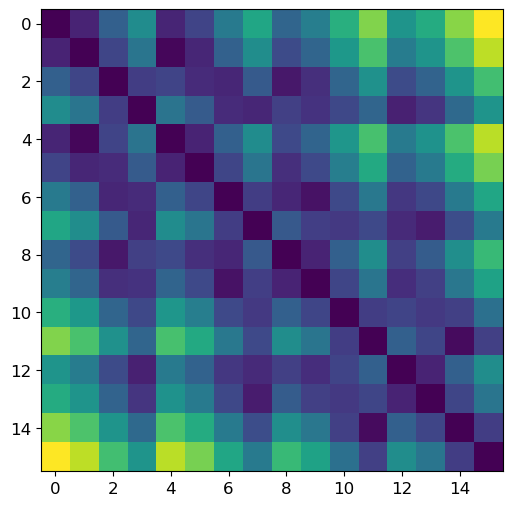

In [1821]:
plt.imshow(np.array(dmb_acc).mean(axis=0))

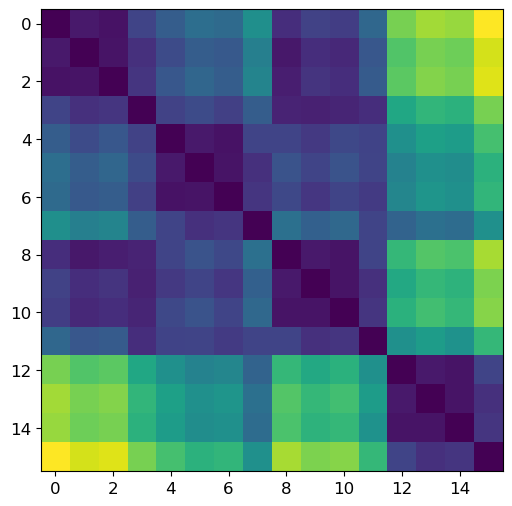

In [1822]:
plt.imshow(np.array(dmb_inacc).mean(axis=0))

In [1820]:
dmb_acc = [dms_b[2][i] for i in acc_ind ]
dmb_inacc = [dms_b[2][i] for i in inacc_ind ]

In [1832]:
len(dmb_inacc)/len(dms_b[2])

0.4725